In [2]:


import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import logging, os
import matplotlib.pyplot as plt
import time

BASE_PATH = "../../../../../local_data/practice/tfds/"
DATA_PATH = "../../../../../local_data/tfds/"
OUTPUT_PATH = BASE_PATH+"mnist_transfer/"
os.system("mkdir -p " + OUTPUT_PATH)

train_dataset, validation_dataset = tfds.load(
    "mnist",
    data_dir=DATA_PATH,
    split=["train[:40%]", "train[40%:50%]"],
    as_supervised=True,  # Include labels
)

print(f"Number of training samples: {tf.data.experimental.cardinality(train_dataset)}")
print(f"Number of validation samples: {tf.data.experimental.cardinality(validation_dataset)}")

Number of training samples: 24000
Number of validation samples: 6000


2025-07-20 20:22:25.683002: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-07-20 20:22:25.683273: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-07-20 20:22:25.745424: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

2025-07-20 20:22:26.100589: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


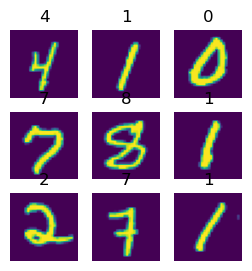

In [3]:
plt.figure(figsize=(3, 3))
for i, (image, label) in enumerate(train_dataset.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(int(label))
    plt.axis("off")

In [4]:
def reshape_image(image, label):
    image = tf.reshape(image, (28, 28, 1))
    return image, label

train_dataset = train_dataset.map(reshape_image)   
def convert_to_rgb(image, label):
    image = tf.image.grayscale_to_rgb(image)
    return image, label

train_dataset = train_dataset.map(convert_to_rgb)   
validation_dataset = validation_dataset.map(convert_to_rgb)   

2025-07-20 20:22:26.608927: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


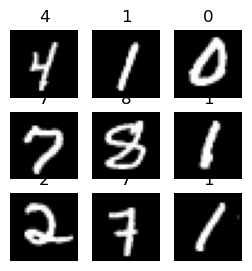

In [5]:
plt.figure(figsize=(3, 3))
for i, (image, label) in enumerate(train_dataset.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(int(label))
    plt.axis("off")

In [6]:
size = (150, 150)

# train_dataset = train_dataset.map(lambda x, y: (tf.image.resize(x, size)/ 255.0, y))
# validation_dataset = validation_dataset.map(lambda x, y: (tf.image.resize(x, size)/ 255.0, y))
train_dataset = train_dataset.map(lambda x, y: (tf.image.resize(x, size), y))
validation_dataset = validation_dataset.map(lambda x, y: (tf.image.resize(x, size), y))

batch_size = 32
train_dataset = train_dataset.cache().batch(batch_size).prefetch(buffer_size=10)
validation_dataset = validation_dataset.cache().batch(batch_size).prefetch(buffer_size=10)

data_augmentation = keras.Sequential(
    [layers.RandomFlip("horizontal"), layers.RandomRotation(0.1),]
)

In [7]:
base_model = keras.applications.Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

In [8]:
# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(150, 150, 3))
x = data_augmentation(inputs)  # Apply random data augmentation

# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(x)

# The base model contains batchnorm layers. 
# We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, 
# so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(10)(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 150, 150, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 150, 150, 3)       0         
                                                                 
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                             

In [9]:
model.compile(
    # optimizer=tf.keras.optimizers.Adam(0.001),
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

In [10]:
epochs = 4
history =model.fit(train_dataset, epochs=epochs,validation_data=validation_dataset)

Epoch 1/4


2025-07-20 20:22:30.114007: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2025-07-20 20:22:31.446061: I external/local_xla/xla/service/service.cc:168] XLA service 0x7b97d3a2a9d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-07-20 20:22:31.446094: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2025-07-20 20:22:31.446101: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2025-07-20 20:22:31.451312: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1753060951.547609   23346 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


750/750 [==============================] - 20s 22ms/step - loss: 0.6922 - sparse_categorical_accuracy: 0.7762 - val_loss: 0.4028 - val_sparse_categorical_accuracy: 0.8845
Epoch 2/4
750/750 [==============================] - 16s 21ms/step - loss: 0.4421 - sparse_categorical_accuracy: 0.8565 - val_loss: 0.3241 - val_sparse_categorical_accuracy: 0.9028
Epoch 3/4
750/750 [==============================] - 16s 21ms/step - loss: 0.3934 - sparse_categorical_accuracy: 0.8732 - val_loss: 0.2963 - val_sparse_categorical_accuracy: 0.9077
Epoch 4/4
750/750 [==============================] - 16s 21ms/step - loss: 0.3681 - sparse_categorical_accuracy: 0.8787 - val_loss: 0.2735 - val_sparse_categorical_accuracy: 0.9153


Text(0.5, 1.0, 'Training and validation loss')

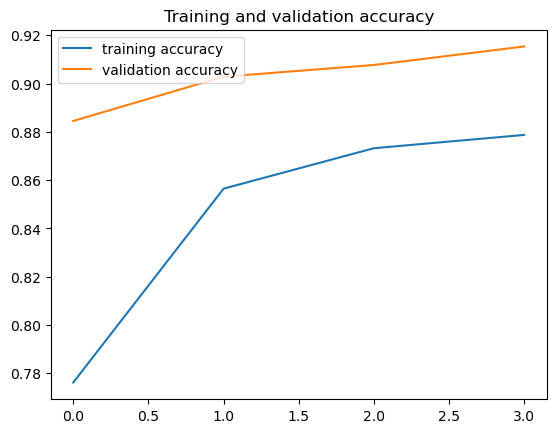

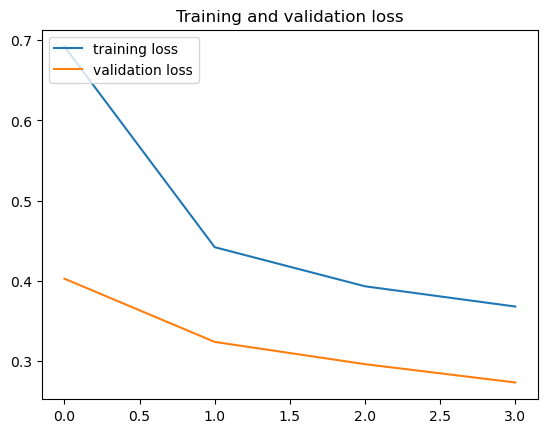

In [11]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history.history[     'sparse_categorical_accuracy' ]
val_acc  = history.history[ 'val_sparse_categorical_accuracy' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs_plot   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  ( epochs_plot,     acc , label="training accuracy")
plt.plot  ( epochs_plot, val_acc, label="validation accuracy" )
plt.title ('Training and validation accuracy')
plt.legend(loc="upper left")
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  ( epochs_plot,     loss , label="training loss")
plt.plot  ( epochs_plot, val_loss , label="validation loss" )
plt.legend(loc="upper left")
plt.title ('Training and validation loss'   )

In [12]:
# Save model
timestr = time.strftime("%Y%m%d-%H%M%S")
acc=val_acc[-1] # last element
filename = f"valacc_{acc:.3f}_epochs_{epochs}_date_{timestr}.h5"
fullpath = f"{OUTPUT_PATH}{filename}"
print("Saving model to ", filename)
model.save(fullpath)

Saving model to  valacc_0.915_epochs_4_date_20250720-202335.h5


/media/data/miniconda3/envs/jh_class/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
